In [181]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt

%matplotlib inline 

In [207]:
def compute_err(M, N):
    # compute prediction error 
    return np.sum(np.square(np.subtract(M, N)))

### Wrangle Data
Wrangle raw data files into Pandas DataFrame. Ratings DataFrame, `df_ratings` is what we will use to train our Matrix Decomposition

In [183]:
data = {} # container

for d in ['ratings', 'users', 'movies']:
    with open("./data/ml-1m/{}.dat".format(d), "r") as file:
         data[d] = np.array([l.strip().split("::") for l in file.readlines()])
            
df_ratings = pd.DataFrame(data['ratings'], columns = ['User_ID', 'Movie_ID', 'Rating', 'Timestamp'])
df_movies  = pd.DataFrame(data['movies'],  columns = ['Movie_ID', 'Title', 'Genre'])
df_users   = pd.DataFrame(data['users'],   columns = ['User_ID', 'Sex', 'Age', 'Occupation', 'ZIP'])

df_ratings['Rating'] = df_ratings['Rating'].astype(np.int)
df_R = df_ratings.pivot(index = 'User_ID', columns = 'Movie_ID', values = 'Rating').fillna(0)

### Modelling
As expected, the training error decreases as the number of factors increases since the model becomes more flexible.

Text(0,0.5,'total squared error')

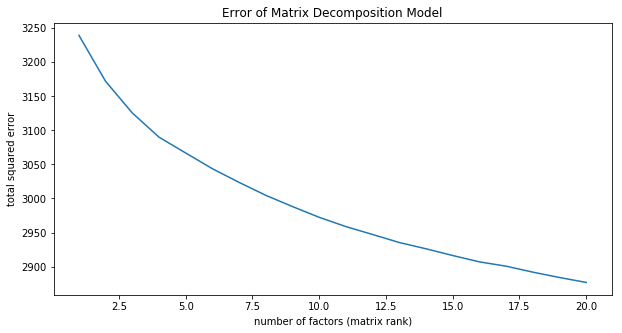

In [142]:
error = {} # container 
for k in range(1, 21):
    model = NMF(n_components=k, init='random', random_state=0)
    W = model.fit_transform(R)
    error[k] = model.reconstruction_err_
    
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(range(1,21), error.values())
ax.set_title("Error of Matrix Decomposition Model")
ax.set_xlabel("number of factors (matrix rank)")
ax.set_ylabel("total squared error")

### Cross-Validation
Now, we obvserve the testing error as the number of factors increases. Performance doesn't appear to improve past k = 20.

In [168]:
# indicator matrix of positive (rated) entries 
R_ind = (R > 0).astype(int) # 1000209

# co-ordinates of positive (rated) entries
ii = np.nonzero(R_ind)
ind_coor = tuple(zip(*ii))

In [193]:
# train test split 
ind_coor_train, ind_coor_test = train_test_split(ind_coor, test_size = 0.2)

# indicator matrix of positive entries (split into train/test)
R_ind_tr = np.zeros_like(R)
R_ind_te = np.zeros_like(R)

for c in ind_coor_train:
    R_ind_tr[c] = 1 
for c in ind_coor_test:
    R_ind_te[c] = 1
    
# rating matrix (split into train/test)
R_train = np.multiply(R, R_ind_tr)
R_test  = np.multiply(R, R_ind_te)

In [241]:
R_train.sum() + R_test.sum()

3582313.0

In [242]:
R.sum()

3582313.0

In [243]:
k_list = []
re_err_list = []
tr_err_list = []
te_err_list = []

for k in range(1, 31):
    model = NMF(n_components=k, init='random', random_state=0)
    W = model.fit_transform(R_train)
    H = model.components_
    Rhat = np.matmul(W, H)
        
    k_list.append(k)
    re_err_list.append(compute_err(R, np.multiply(Rhat, R_ind)))
    tr_err_list.append(compute_err(R_train, np.multiply(Rhat, R_ind_tr)))  
    te_err_list.append(compute_err(R_test, np.multiply(Rhat, R_ind_te)))  

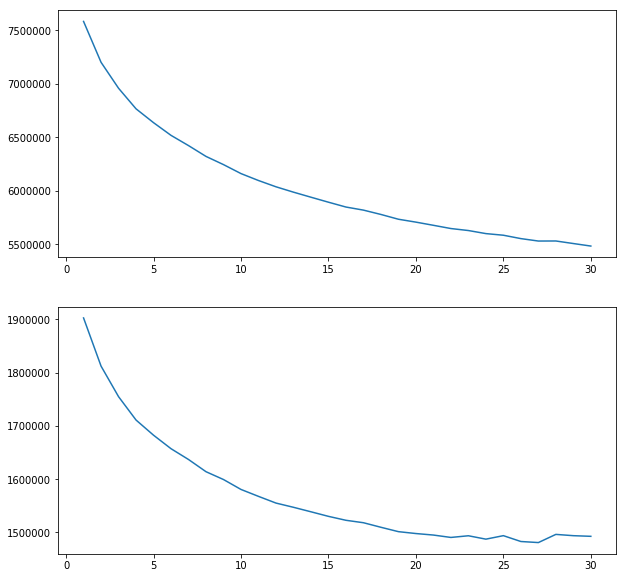

In [244]:
fig, ax = plt.subplots(2,1, figsize=(10,10))
ax[0].plot(k_list, tr_err_list)
ax[0].set_title("Training Error of Matrix Decomposition Model")
ax[1].plot(k_list, te_err_list)
ax[1].set_title("Testing Error of Matrix Decomposition Model")
ax[1].set_xlabel("number of fac")

### Inspect Results
Now look at results case by case

In [221]:
(df_R > 0).sum(axis=1).sort_values(ascending=True).head() # people who have reviewed the fewest movies 

User_ID
5145    20
2381    20
4178    20
4192    20
421     20
dtype: int64

In [134]:
def get_reviewed_movies(userid, k):
    """ Get the top $k movies reviewed by $userid """
    rev_cols     = df_R.columns[df_R.loc[userid,:] > 0]
    rev_movieids = df_R.loc[userid, rev_cols].sort_values(ascending=False)[:k].index
    return rev_movieids

In [128]:
def make_recommendation(userid, k):
    """ Make top $k movie recommendations for $userid """
    unrev_cols   = df_R.columns[df_R.loc[userid,:] == 0]
    rec_movieids = df_Rhat.loc[userid, unrev_cols].sort_values(ascending=False)[:k].index
    return rec_movieids

In [136]:
df_movies[df_movies['Movie_ID'].isin(get_reviewed_movies('5145', 10))]

,Movie_ID,Title,Genre
2083,2152,Air Bud: Golden Receiver (1998),Children's|Comedy
2693,2762,"Sixth Sense, The (1999)",Thriller
2789,2858,American Beauty (1999),Comedy|Drama
2890,2959,Fight Club (1999),Drama
2928,2997,Being John Malkovich (1999),Comedy
2983,3052,Dogma (1999),Comedy
3012,3081,Sleepy Hollow (1999),Horror|Romance
3076,3145,"Cradle Will Rock, The (1999)",Drama
3107,3176,"Talented Mr. Ripley, The (1999)",Drama|Mystery|Thriller
3673,3742,"Battleship Potemkin, The (Bronenosets Potyomki...",Drama|War


In [133]:
df_movies[df_movies['Movie_ID'].isin(make_recommendation('5145', 10))]

,Movie_ID,Title,Genre
49,50,"Usual Suspects, The (1995)",Crime|Thriller
293,296,Pulp Fiction (1994),Crime|Drama
315,318,"Shawshank Redemption, The (1994)",Drama
523,527,Schindler's List (1993),Drama|War
589,593,"Silence of the Lambs, The (1991)",Drama|Thriller
604,608,Fargo (1996),Crime|Drama|Thriller
1575,1617,L.A. Confidential (1997),Crime|Film-Noir|Mystery|Thriller
1656,1704,Good Will Hunting (1997),Drama
1959,2028,Saving Private Ryan (1998),Action|Drama|War
2327,2396,Shakespeare in Love (1998),Comedy|Romance
